In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *
from torch.utils.data import DataLoader, Dataset
from torch import nn
from fastai.callbacks.hooks import num_features_model, model_sizes
from fastai.layers import BCEWithLogitsFlat
from fastai.basic_train import Learner
from skimage.util import montage
import pandas as pd
from torch import optim
import re

from utils import *

In [4]:
seed=43

In [5]:
SZ = 224
BS = 64
NUM_WORKERS = 4

# A look at the data

In [4]:
path = Path('data')

In [5]:
path.ls()

[PosixPath('data/val_fns_detection.pkl'),
 PosixPath('data/train-224'),
 PosixPath('data/.blank'),
 PosixPath('data/sloth_config.py'),
 PosixPath('data/train'),
 PosixPath('data/train.csv'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/test-224'),
 PosixPath('data/test.zip'),
 PosixPath('data/models'),
 PosixPath('data/train.zip'),
 PosixPath('data/test'),
 PosixPath('data/annotations.json')]

In [40]:
df = pd.read_csv('data/train.csv')
print(df.shape)
df.tail()

(25361, 2)


,Image,Id
25356,ffef89eed.jpg,w_9c506f6
25357,fff7faf61.jpg,w_9cf0388
25358,fff9002e0.jpg,w_bd1c3d5
25359,fffcde6fe.jpg,w_9f30885
25360,fffde072b.jpg,new_whale


In [41]:
vc = df.Id.value_counts().sort_values(ascending=False)

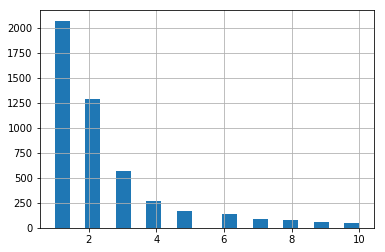

In [25]:
vc[vc<=10].hist(bins=20)

In [35]:
(df.Id == 'new_whale').mean(),(vc<=10).mean()

(0.3810575292772367, 0.9544455544455545)

# Oversampling on known imgs (no new_whale)

In [84]:
pd.read_csv('data/train.csv').Id.value_counts().max()

9664

In [138]:
df = pd.read_csv('data/train.csv')

In [139]:
df = df[df.Id != 'new_whale']

In [140]:
vc = df.Id.value_counts()
df['label_count'] = df.Id.map(vc)

In [141]:
df.shape

(15697, 3)

In [142]:
df.head()

,Image,Id,label_count
0,0000e88ab.jpg,w_f48451c,14
1,0001f9222.jpg,w_c3d896a,4
2,00029d126.jpg,w_20df2c5,4
6,000a6daec.jpg,w_dd88965,16
8,0016b897a.jpg,w_64404ac,5


## val set: first row of each group not 'new_whale' and every label has >=2 images 

In [143]:
val_fns=df[(df.label_count>1)].groupby('Id').first().sample(frac=1,random_state=seed).Image.values

In [144]:
len(val_fns)

2931

In [145]:
# fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}

In [146]:
# path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [147]:
# (path/'train').ls()[0],path2fn(str((path/'train').ls()[0]))

(PosixPath('data/train/26bb255b5.jpg'), '26bb255b5.jpg')

In [135]:
# pd.to_pickle(val_fns,path/'val_fname_no_nw.pkl')

## Train and val set

In [148]:
df_val = df[df.Image.isin(val_fns)]
df_train = df[~df.Image.isin(val_fns)]

In [87]:
df_val.shape, df_train.shape, df.shape

((2931, 3), (12766, 3), (15697, 3))

## Oversampling low label_count with replacement

In [137]:
def oversampling(df,row_per_grp=15):
    '''
    For each group with <15 rows, upsample to 15. Otherwise leave them alone
    '''
    res = df.sample(0)
    for g in df.groupby('Id'):
        curr_n = g[1].shape[0]
        addi_n = 0 if curr_n >= row_per_grp else row_per_grp - curr_n
        addi_rows = g[1].sample(addi_n,replace=True)
        rows = pd.concat([g[1],addi_rows])
        res = pd.concat([res,rows])
    return res

In [123]:
over_df= oversampling(df)

In [124]:
over_df.shape

(76287, 3)

In [131]:
over_df.Id.value_counts().value_counts().sort_index().head()

15    4891
16      16
17      17
18       6
19       8
Name: Id, dtype: int64

In [126]:
# over_df.to_pickle(path/'oversample_no_nw.pkl')

In [149]:
over_df= oversampling(df_train)
# over_df.to_pickle(path/'oversample_no_nw_train.pkl')

In [150]:
over_df.shape

(76174, 3)

# Simple training (no oversampling)

In [7]:
df = pd.read_csv('data/train.csv')

df = df[df.Id != 'new_whale']

vc = df.Id.value_counts()
df['label_count'] = df.Id.map(vc)

val_fns=df[(df.label_count>1)].groupby('Id').first().sample(frac=1,random_state=seed).Image.values

In [10]:
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)
fn2label = {row[1].Image: row[1].Id for row in pd.read_csv('data/train.csv').iterrows()}

In [14]:
df.head()

,Image,Id,label_count
0,0000e88ab.jpg,w_f48451c,14
1,0001f9222.jpg,w_c3d896a,4
2,00029d126.jpg,w_20df2c5,4
6,000a6daec.jpg,w_dd88965,16
8,0016b897a.jpg,w_64404ac,5


In [15]:
data = (
    ImageList
        .from_df(df, 'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageList.from_folder('data/test'))
        .transform(get_transforms(do_flip=True), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

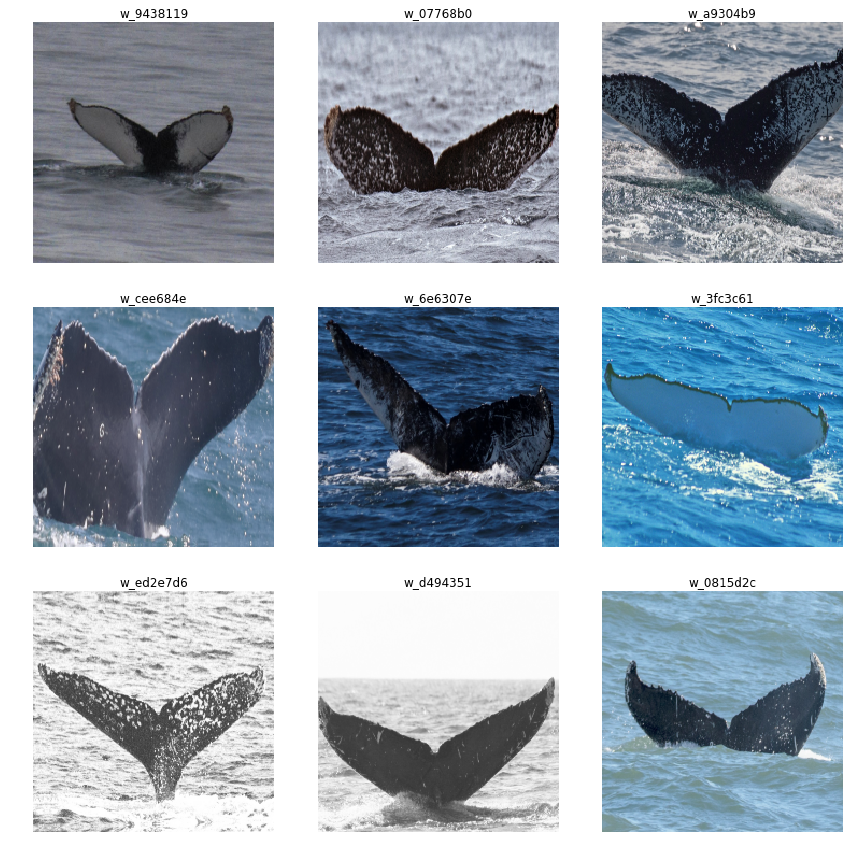

In [16]:
data.show_batch(3)

In [25]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, map5])

In [23]:
# learn = learn.mixup()

In [24]:
# learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,map5,time
0,7.961442,8.037020,0.015012,0.023559,01:55
1,6.869823,7.455200,0.043330,0.060611,01:50


In [26]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,map5,time
0,7.670764,8.113168,0.018083,0.028227,01:50
1,6.123642,7.247193,0.059707,0.083004,01:49


# Siamese network

In [3]:
# new architecture calls for a new validation set, 
# this time our validation set will consist of all whales that have exactly two images
df = pd.read_csv('data/train.csv')
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')
val_fns = set(df[df.sighting_count == 2].Image)

In [6]:
len(val_fns)

2570

In [4]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

name = f'res18-siamese'

In [8]:
classes = df.Id.unique() # get all classes from train and val set

In [18]:
SZ = 224
BS = 64
NUM_WORKERS =8
SEED=42

## Create data

In [19]:
data = (
    ImageList
        .from_df(df[df.Id != 'new_whale'], f'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageList.from_folder(f'data/test'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
#         .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
#         .normalize(imagenet_stats)
)

In [20]:
class TwoImDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds
        self.whale_ids = ds.y.items
    def __len__(self):
        return 2 * len(self.ds)
    def __getitem__(self, idx):
        '''
        For even idx, create same-label record: img1 (anchor), img2 (positive), binary-label 1 meaning 2 imgs from same class
        For odd idx, create different-label record: img1 (anchor), img2 (negative), binary-label 0 meaning 2 imgs with different classes
        For now, anchor,positive and negative are chosen randomly. Ideally, A and N should be somewhat similar, 
        thus make model harder to distinguish
        '''
        if idx%2==0:
            return self.sample_same(idx // 2)
        return self.sample_different((idx-1) // 2) # or just idx//2 will be fine
    
    def sample_same(self, idx):
        '''
        return 2 images of same class: 1 from idx, 1 from random dist (same class)
        if class only have 1 img, use sample_different
        ''' 
        whale_id = self.whale_ids[idx]        
        candidates = list(np.where(self.whale_ids == whale_id)[0]) # idxs of img with same whale_id
        candidates.remove(idx) # dropping our current whale - we don't want to compare against an identical image!
        
        if len(candidates) == 0: # oops, there is only a single whale with this id in the dataset
            return self.sample_different(idx)
        
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 1)
    def sample_different(self, idx):
        '''
        return 2 images of different class: 1 from idx, 1 from random dist (diff class)
        '''
        whale_id = self.whale_ids[idx]
        candidates = list(np.where(self.whale_ids != whale_id)[0])
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 0)
    
    def construct_example(self, im_A, im_B, class_idx):
        return [im_A, im_B], class_idx

In [55]:
temp_tr = TwoImDataset(data.train)

In [56]:
temp_tr[0]

([Image (3, 224, 224), Image (3, 224, 224)], 1)

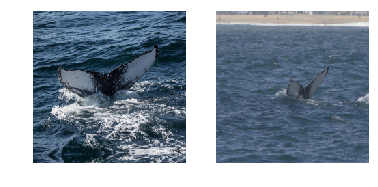

In [57]:
fig,axes = plt.subplots(1,2)
show_image(temp_tr[0][0][0],axes[0])
show_image(temp_tr[0][0][1],axes[1])

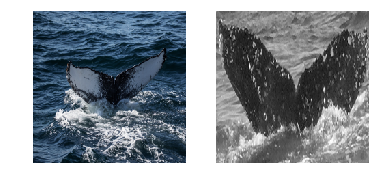

In [63]:
fig,axes = plt.subplots(1,2)
show_image(temp_tr[1][0][0],axes[0])
show_image(temp_tr[1][0][1],axes[1])

In [64]:
train_dl = DataLoader(
    TwoImDataset(data.train),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)
valid_dl = DataLoader(
    TwoImDataset(data.valid),
    batch_size=BS,
    shuffle=False,
    num_workers=NUM_WORKERS
)

In [68]:
data.tfms

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.1947869521427168, 'col_pct': 0.21455138440650512, 'padding_mode': 'reflection'}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([ 0.0954, -0.0798,  0.1393,  0.1294]), 'invert': False}, do_run=False, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={'degrees': -0.8524419369472724}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={'scale': 1.0108577813631665, 'row_pct': 0.9209779440956084, 'col_pct': 0.5454390738375491}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, 

In [65]:
data_bunch = ImageDataBunch(train_dl, valid_dl)

In [70]:
temp=next(iter(data_bunch.train_dl))

In [73]:
temp[1].shape

torch.Size([64])

In [77]:
len(temp[0]),temp[0][0].shape,temp[0][1].shape,temp

(2, torch.Size([64, 3, 224, 224]), torch.Size([64, 3, 224, 224]))

In [67]:
data_bunch.tfms

[]

In [78]:
def normalize_batch(batch):
    # normalize 2 imgs
    stat_tensors = [torch.tensor(l).cuda() for l in imagenet_stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [79]:
data_bunch.add_tfm(normalize_batch)

In [80]:
data_bunch.tfms

[<function __main__.normalize_batch(batch)>]

## Create model

In [81]:
class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        # cut of pooling + fully connected layer of imgnet
        self.cnn = create_body(arch)
        self.head = nn.Linear(num_features_model(self.cnn), 1)
        
    def forward(self, im_A, im_B):
        # im: (bs,3,224,224)
        x1 = self.cnn(im_A) # (bs,512,7,7)
        x1 = self.process_features(x1) # (bs,512)
        
        x2 = self.cnn(im_B)
        x2 = self.process_features(x2)
        
        # dl - distance layer
        # here we use absolute positional invariance 
        # through the use of global max pooling
        
#         x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)
        dl = self.calculate_distance(x1, x2) # (bs,512)
        out = self.head(dl) # (bs,1)
        return out
    
    def process_features(self, x): 
        '''
        x shape: [bs, 512, 7, 7]
        output: [bs,512]
        '''
        return x.reshape(*x.shape[:2], -1).max(-1)[0] # global max pooling
    def calculate_distance(self, x1, x2): 
        return (x1 - x2).abs_()
    

In [82]:

learn = Learner(data_bunch, 
                SiameseNetwork(), 
                loss_func=BCEWithLogitsFlat(), # binary cross entropy
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/quantran/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:16<00:00, 2844101.50it/s]


In [86]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head]);

In [87]:
len(learn.layer_groups)

3

In [88]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


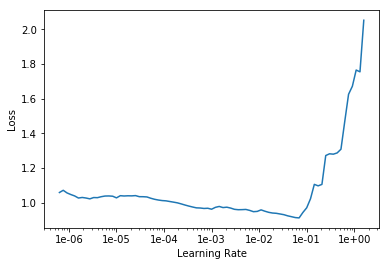

In [89]:
learn.lr_find()
learn.recorder.plot()

# Fluke box detection

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
import cv2
import types

from utils import *

In [2]:
j = json.load(open('data/annotations.json'))

In [3]:
j[0]

{'annotations': [{'class': 'fluke',
   'height': 372.0,
   'type': 'rect',
   'width': 1017.0,
   'x': 14.0,
   'y': 97.0},
  {'class': 'left',
   'type': 'point',
   'x': 50.802273527488566,
   'y': 98.58659021176},
  {'class': 'notch',
   'type': 'point',
   'x': 516.2391276137811,
   'y': 269.48861474128864},
  {'class': 'right',
   'type': 'point',
   'x': 1013.5305065138045,
   'y': 102.10753986218477}],
 'class': 'image',
 'filename': '6138dce83.jpg'}

In [4]:
SZ = 224
BS = 64
NUM_WORKERS = 12

(x, y, width, height) -> (y_upper_left, x_upper_left, y_lower_right, x_lower_right)

In [5]:
list(filter(lambda a: a%2==0,[0,1,2,3,4]))

[0, 2, 4]

In [6]:
j[0]['annotations'][0]

{'class': 'fluke',
 'height': 372.0,
 'type': 'rect',
 'width': 1017.0,
 'x': 14.0,
 'y': 97.0}

The fastai library expects bbox coordinates to be in the format of (y_upper_left, x_upper_left, y_lower_right, x_lower_right) with the origin being in the upper left hand corner of the image.

In [7]:
def anno2bbox(anno): # (upper left, lower right coord scale to 224)
    im_width, im_height = PIL.Image.open(f"data/train/{anno['filename']}").size
    anno = list(filter(lambda a: a['class'] == 'fluke', anno['annotations']))[0] # filter out fluke dict
    return [
        np.clip(anno['y'], 0, im_height) / im_height * SZ, #scale bbox to 224 (or SZ)
        np.clip(anno['x'], 0, im_width) / im_width * SZ,
        np.clip(anno['y']+anno['height'], 0, im_height) / im_height * SZ,
        np.clip(anno['x']+anno['width'], 0, im_width) / im_width * SZ
    ]

In [8]:
fn2bbox = {jj['filename']: [[anno2bbox(jj)], ['fluke']] for jj in j}
fn2bbox['6138dce83.jpg']

[[[36.21333333333333,
   2.986666666666667,
   175.09333333333333,
   219.9466666666667]],
 ['fluke']]

In [9]:
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)
get_y_func = lambda path: fn2bbox[path2fn(path)]

In [10]:
val_fns = pd.read_pickle('data/val_fns_detection.pkl') # random 100 images in the annotation json

In [11]:
val_fns[:5]

['0dcfd05bf.jpg',
 '53bb428e9.jpg',
 '6ddd0e118.jpg',
 '9b7b61f03.jpg',
 '031e52425.jpg']

In [12]:
class StubbedObjectCategoryList(ObjectCategoryList):
    # label class
    # we will be predicting just a single bounding box per image 
    
    # add a dummy torch.ones(1) as 'label', in order to use ObjectCategoryList
    def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()] 

## Create data

In [13]:
# TODO: look at other object detection to understand this better
data = (ObjectItemList.from_df(pd.DataFrame(data=list(fn2bbox.keys())), path='data/train-224')
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)                         
        .label_from_func(get_y_func, label_cls=StubbedObjectCategoryList)
        .transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats))

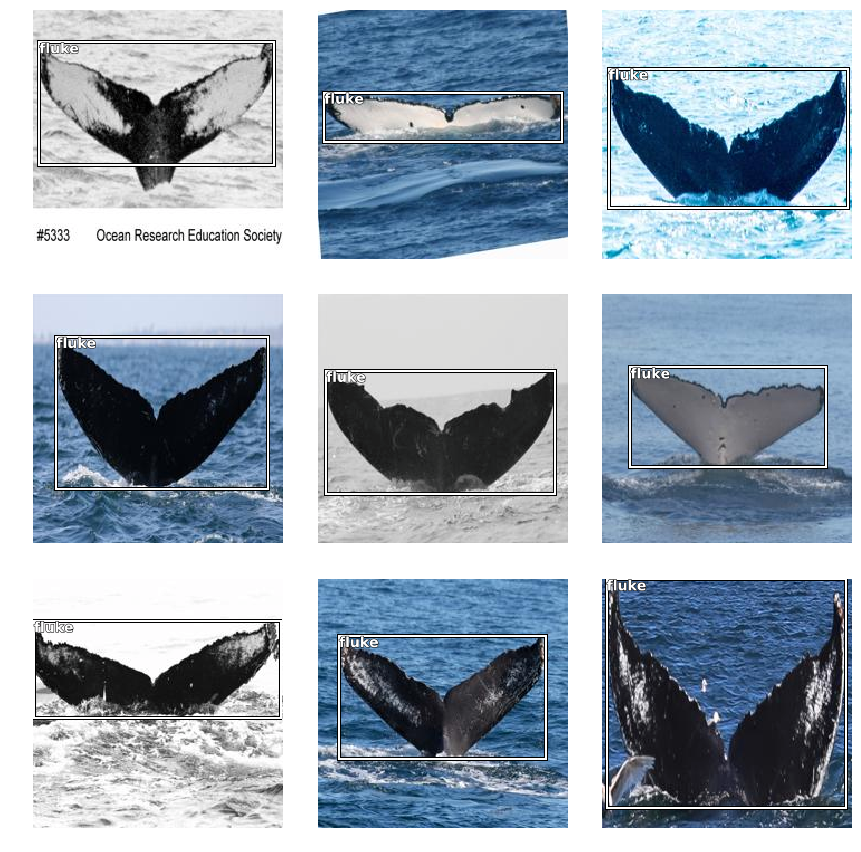

In [14]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(12,12))

In [15]:
data.valid_ds.items[0] # raw item: img path

'data/train-224/0dcfd05bf.jpg'

In [16]:
data.valid_ds[0] # raw item converted to Image obj + bbox

(Image (3, 224, 224), ImageBBox (224, 224))

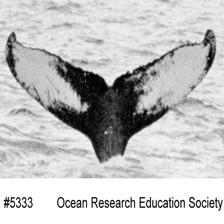

In [17]:
# ... which is ...
data.valid_ds.x[0] 

In [18]:
#... and ...
data.valid_ds.y[0]

ImageBBox (224, 224)

In [19]:
data.valid_ds.y[0].data

(tensor([[-0.7440, -0.9571,  0.2400,  0.9257]]), array([1]))

In [20]:
x,y = next(iter(data.valid_dl))

In [21]:
x.shape

torch.Size([64, 3, 224, 224])

In [22]:
len(y)

2

In [23]:
y[0].shape,y[1].shape

(torch.Size([64, 1, 4]), torch.Size([64, 1]))

In [24]:
y[0][0] # Note: coords being scaled!

tensor([[-0.7440, -0.9571,  0.2400,  0.9257]], device='cuda:0')

In [25]:
y[1][:5,:] # dummy. See above

tensor([[1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')

## Create model

In [26]:
create_body(models.resnet18)[-1]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, mome

In [27]:
num_features_model(create_body(models.resnet18)) * 2

1024

In [28]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch) # last conv2d->batchnorm: 512,7,7
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        # add adapconcat and 2 nn.linear: 1024 to 512, 512 to 4 (coords) with bn,dropout ...
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5) #scaling between -1 and 1. 

In [29]:
temp_model = FlukeDetector()

In [30]:
list(temp_model.children())[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=4, bias=True)
)

In [31]:
def loss_fn(preds, targs, class_idxs): # ignore class idxs
    return L1Loss()(preds, targs.squeeze())

In [32]:
learn = Learner(data, FlukeDetector(arch=models.resnet50), loss_func=loss_fn)
# IOU metric
learn.metrics = [lambda preds, targs, _: IoU(preds, targs.squeeze()).mean()]

In [33]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head]);

In [34]:
learn.freeze_to(-1)

In [35]:
%time learn.fit_one_cycle(25, 1e-2, div_factor=12, pct_start=0.2)

epoch,train_loss,valid_loss,,time
0,0.784186,0.710008,0.000208,00:05
1,0.775124,0.698175,0.003348,00:02
2,0.757609,0.669871,0.027483,00:02
3,0.711606,0.405180,0.289345,00:02
4,0.628576,0.171979,0.637129,00:02
5,0.535483,0.152742,0.670099,00:02
6,0.464397,0.156637,0.649666,00:02
7,0.409787,0.143517,0.676366,00:02
8,0.366687,0.116935,0.690390,00:02
9,0.331157,0.104709,0.722314,00:02


CPU times: user 30.7 s, sys: 22.7 s, total: 53.3 s
Wall time: 1min 15s


In [36]:
learn.unfreeze()

max_lr = 1e-3
lrs = np.array([max_lr/100, max_lr/10, max_lr])

%time learn.fit_one_cycle(120, lrs)

epoch,train_loss,valid_loss,,time
0,0.072290,0.071725,0.801531,00:04
1,0.072988,0.070958,0.803784,00:03
2,0.072863,0.070494,0.804803,00:03
3,0.072488,0.070147,0.805808,00:03
4,0.071088,0.070041,0.806431,00:03
5,0.070174,0.070050,0.806671,00:03
6,0.069451,0.070215,0.806099,00:03
7,0.069044,0.069933,0.806520,00:03
8,0.068987,0.069111,0.808195,00:03
9,0.068624,0.068525,0.808817,00:03


CPU times: user 3min 7s, sys: 2min 19s, total: 5min 27s
Wall time: 7min 10s


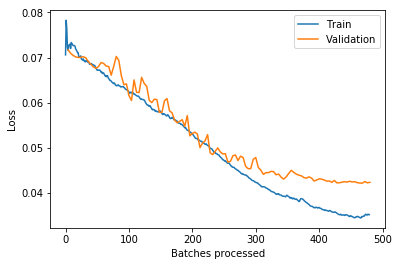

In [37]:

learn.recorder.plot_losses()

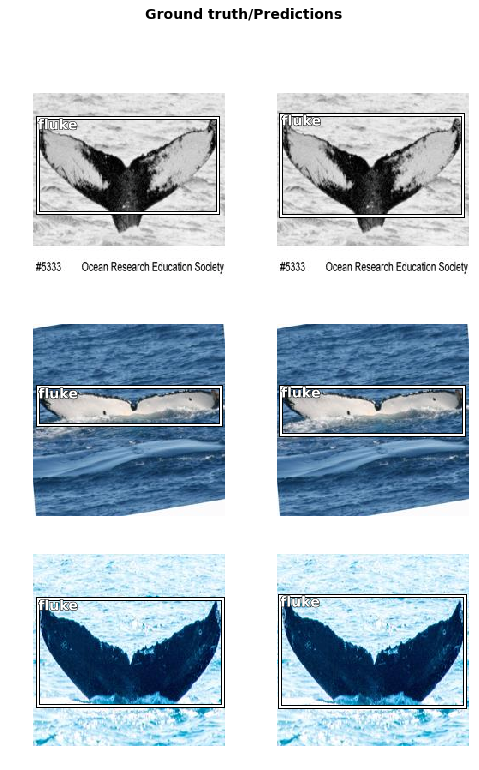

In [38]:
learn.show_results(rows=3)

In [39]:
# learn.save('fluke_detector')

# Extract bboxes

In [43]:
def paths_to_files_in(dir):
    paths = []
    for path in Path(dir).iterdir():
        if path.is_dir():
            paths += paths_to_files_in(path)
        else:
            paths.append(path)
    return paths

def open_image(path): return PIL.Image.open(path).convert('RGB')

def image2ary(image): return np.asarray(image)

def ary2tensor(ary, dtype=np.float32): return torch.from_numpy(ary.astype(dtype, copy=False))

def image2tensor(image, augment_fn=None):
    ary = image2ary(image)
    if augment_fn: ary = augment_fn(ary)
    ary = ary.transpose(2, 0, 1)
    tensor = ary2tensor(ary)
    return tensor.div_(255)

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
mean, std = torch.from_numpy(np.array(imagenet_stats).astype(np.float32))

def imagenet_normalize(tensor):
    zero_centered = tensor - mean[:, None, None]
    return zero_centered / std[:, None, None]

def imagenet_denormalize(zero_centered):
    zero_centered = zero_centered * std[:, None, None]
    return zero_centered + mean[:, None, None]


In [ ]:
class Dataset():
    def __init__(self, items, reader, labeler):
        self.items, self.reader, self.labeler = items, reader, labeler

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items[idx]
        return self.reader(item), self.labeler(item)


In [44]:
class Reader():
    def __init__(self, path):
        self.path = path
    def __call__(self, item):
        image_path = f'{self.path}/{item}'
        image = open_image(image_path)
        tensor = image2tensor(image)
        return imagenet_normalize(tensor)

In [45]:
temp_reader = Reader('data/train-224')

In [47]:
temp_reader('0000e88ab.jpg')

tensor([[[-1.5699, -1.6213, -1.4500,  ..., -0.9877, -0.6281, -0.5082],
         [-0.8849, -0.9705, -0.8164,  ..., -1.6042, -1.4158, -1.4329],
         [-0.5082, -0.3883, -0.2684,  ..., -1.1589, -1.1760, -1.2617],
         ...,
         [-1.1075, -1.0733, -0.9877,  ..., -0.1657, -0.1143, -0.0287],
         [-1.0733, -1.1418, -1.2103,  ..., -1.4672, -1.5870, -1.7240],
         [-1.7069, -1.7583, -1.8268,  ..., -1.7069, -1.9638, -1.5357]],

        [[-1.0203, -1.0728, -0.8978,  ..., -0.5126, -0.1450, -0.0224],
         [-0.3200, -0.4076, -0.2500,  ..., -1.1429, -0.9503, -0.9678],
         [ 0.0651,  0.1877,  0.3102,  ..., -0.6352, -0.6527, -0.7402],
         ...,
         [-0.6352, -0.6001, -0.5126,  ...,  0.2052,  0.2577,  0.3452],
         [-0.6001, -0.6702, -0.7402,  ..., -1.1253, -1.2479, -1.3880],
         [-1.2479, -1.3004, -1.3704,  ..., -1.3704, -1.6331, -1.1954]],

        [[-0.3578, -0.4101, -0.2358,  ...,  0.2173,  0.5834,  0.7054],
         [ 0.3393,  0.2522,  0.4091,  ..., -0

Reader will read the image file from disk and return a tensor.

Since we don't care about the labels, the labeler will always return a 0.

In [48]:

train_ds = Dataset(pd.read_csv('data/train.csv').Image, Reader('data/train-224'), lambda item: 0)

fns = [p.name for p in paths_to_files_in('data/test-224')]
test_ds = Dataset(fns, Reader('data/test-224'), lambda item: 0)

In [49]:
NUM_WORKERS = 12
BS = 64

train_dl = DataLoader(train_ds, batch_size=BS, num_workers=NUM_WORKERS)
test_dl = DataLoader(test_ds, batch_size=BS, num_workers=NUM_WORKERS)

In [50]:
x,y= next(iter(train_dl))

In [52]:
x.shape,y.shape,y[:5]

(torch.Size([64, 3, 224, 224]), torch.Size([64]), tensor([0, 0, 0, 0, 0]))

In [53]:
data = DataBunch(train_dl, test_dl)

```python
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch) # last conv2d->batchnorm: 512,7,7
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        # add adapconcat and 2 nn.linear: 1024 to 512, 512 to 4 (coords) with bn,dropout ...
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5) #scaling between -1 and 1. 
```

In [ ]:
def loss_fn(preds, targs, class_idxs): return L1Loss()(preds, targs.squeeze())

Note that even though the databunch we use to train bbox Fluke Detector with y as ((1,4) bbox coordinate and labels) (for object detection to work), it does not really matter when we use another databunch with different y. It will work as long as x is the same (bs,3,224,224)

In [56]:
learn = Learner(data, FlukeDetector(arch=models.resnet50), loss_func=loss_fn)
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head]);

# Note: no need for IOU metric. We only want the output of the detector model
# learn.metrics = [lambda preds, targs, _: IoU(preds, targs.squeeze()).mean()]

In [64]:
learn.metrics 

[]

In [59]:
state_dict = torch.load('data/train-224/models/fluke_detector.pth')

In [60]:
learn.model.load_state_dict(state_dict['model'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [66]:
temp_pred = learn.model(x.cuda())

In [67]:
temp_pred.shape

torch.Size([64, 4])

In [61]:
train_preds, _ = learn.get_preds(DatasetType.Train)
test_preds, _ = learn.get_preds(DatasetType.Valid)

In [68]:
test_preds.shape

torch.Size([7960, 4])

In [69]:
test_preds[0]

tensor([-0.6684, -0.9339,  0.4542,  0.9268])

In [70]:
def extract_bbox(fn, scaled_coords, directory='train'):
    im = open_image(f'data/{directory}/{fn}')
    width, heigth = im.size
    ary = np.asarray(im)
    y_up_left, x_up_left, y_low_right, x_low_right = ((scaled_coords + 1)  / 2).clamp(0,1).numpy()
    y_up_left = np.round(y_up_left * heigth)
    x_up_left = np.round(x_up_left * width)

    y_low_right = np.round(y_low_right * heigth)
    x_low_right = np.round(x_low_right * width)

    y_up_left, x_up_left, y_low_right, x_low_right = list(map(int, [y_up_left, x_up_left, y_low_right, x_low_right]))
    return ary[y_up_left:y_low_right, x_up_left:x_low_right]

In [71]:

!rm -rf data/train-extracted-224
!rm -rf data/test-extracted-224

!mkdir data/train-extracted-224
!mkdir data/test-extracted-224

In [73]:
%%time
SZ = 224
for i, fn in enumerate(train_ds.items):
    ary = extract_bbox(fn, train_preds[i])
    if 0 in ary.shape:
        print(f'{fn} - failed to extract bbox')
        continue
    im = PIL.Image.fromarray(ary)
    im = im.resize((SZ, SZ), resample=PIL.Image.BICUBIC)
    im.save(f'data/train-extracted-{SZ}/{fn}')

CPU times: user 4min 2s, sys: 3.93 s, total: 4min 6s
Wall time: 4min 22s


In [74]:
%%time

SZ = 224
for i, fn in enumerate(test_ds.items):
    ary = extract_bbox(fn, test_preds[i], 'test')
    if 0 in ary.shape:
        print(f'{fn} - failed to extract bbox')
        continue
    im = PIL.Image.fromarray(ary)
    im = im.resize((SZ, SZ), resample=PIL.Image.BICUBIC)
    im.save(f'data/test-extracted-{SZ}/{fn}')

CPU times: user 1min 16s, sys: 1.22 s, total: 1min 17s
Wall time: 1min 21s


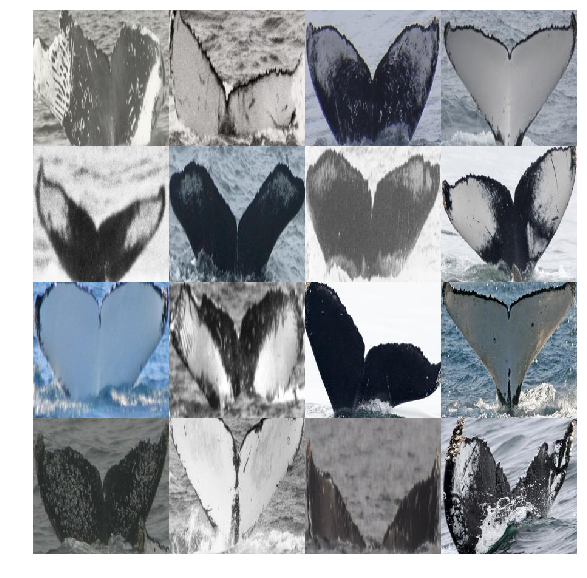

In [75]:

paths = paths_to_files_in('data/test-extracted-224/')
np.random.shuffle(paths)

ims = []
for path in paths[:16]: ims.append(np.asarray(open_image(path)))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

## Get bigger crop: 448

In [ ]:
# SZ = 448

# !rm -rf data/train-extracted-{SZ}
# !rm -rf data/test-extracted-{SZ}

# !mkdir data/train-extracted-{SZ}
# !mkdir data/test-extracted-{SZ}

In [ ]:
# %%time

# for i, fn in enumerate(train_ds.items):
#     ary = extract_bbox(fn, train_preds[i])
#     if 0 in ary.shape:
#         print(f'{fn} - failed to extract bbox')
#         continue
#     im = PIL.Image.fromarray(ary)
#     im = im.resize((SZ, SZ), resample=PIL.Image.BICUBIC)
#     im.save(f'data/train-extracted-{SZ}/{fn}')

In [ ]:
# %%time

# for i, fn in enumerate(test_ds.items):
#     ary = extract_bbox(fn, test_preds[i], 'test')
#     if 0 in ary.shape:
#         print(f'{fn} - failed to extract bbox')
#         continue
#     im = PIL.Image.fromarray(ary)
#     im = im.resize((SZ, SZ), resample=PIL.Image.BICUBIC)
#     im.save(f'data/test-extracted-{SZ}/{fn}')